# ⛵ 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 통해 예측해봅시닷!

분석의 목적!
370개의 feature로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것!

클래스 레이블 이름 : TARGET
##### 1이면 불만을 가진 고객, 0이면 만족한 고객

In [6]:
# 필요한 라이브러리

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time

# sklearn 관련
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# xgboost 관련
from xgboost import XGBClassifier
from xgboost import plot_importance

# lightgbm 관련
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

https://www.kaggle.com/competitions/santander-customer-satisfaction/code
##### 캐글 홈페이지에서 자료를 다운받은 뒤,
- Colab 사용 시 : 화면 왼쪽에 있는 폴더 아이콘을 클릭! train, test 파일을 옮겨놓으면 끝!
- Jupyter Notebook 사용 시 : 작업 중인 폴더 내에 train, test 파일을 업로드 해놓으면 끝!

In [7]:
# 데이터 살펴보기

cust_df = pd.read_csv('train.csv', encoding = 'latin-1')
print(cust_df.shape)
cust_df.head(3)

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


다음과 같이 76020개의 행과 371개의 열을 가진 데이터로, 우리가 예측할 변수는 'TARGET'에 저장되어 있습니다!

In [9]:
cust_df['TARGET'].value_counts() # 0 : 만족, 1 : 불만족

0    73012
1     3008
Name: TARGET, dtype: int64

이 TARGET 변수는 이항형(binary)이고, 만족하는 고객은 14,178명, 만족하지 않는 고객은 597명으로 불만족인 고객은 4% 정도에 불과합니다!

In [10]:
# 데이터 전처리하기

cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


전처리할 변수는 2가지 입니다!
- var3의 최소값이 -999999로 되어 있는데, 이를 가장 값이 많은 2로 변환하고자 합니다!
##### 아마도 특정 예외값 혹은 null값을 -999999로 변환했기 때문!
- ID feature는 단순 식별자이기 때문에 feature를 드롭!

In [11]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

이제 XGBoost와 LightGBM 모형 훈련을 위해 훈련 데이터와 테스트 데이터를 나누는 작업을 해야 합니다! 이를 위해 sklearn의 train_test_split 메서드를 이용했고, 테스트 데이터의 크기와 훈련 데이터의 비율은 2:8로 했습니다!

In [12]:
# X랑 y 나누기

X = cust_df.iloc[:, :-1]
y = cust_df.iloc[:, -1]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(y_train.value_counts() / y_train.count())
print(y_eval.value_counts() / y_eval.count())

0    0.960964
1    0.039036
Name: TARGET, dtype: float64
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


훈련 데이터와 테스트 데이터 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도로 불만족 값이 나오도록 만들어진 것을 확인할 수 있습니다!

## XGBoost 모델 학습 & 하이퍼 파라미터 튜닝

이제 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해봅시다! 그리고 시작과 끝 시간을 재어서 XGBoost와 LightGBM의 수행 속도를 비교해봅시다!

In [13]:
tic = time.time() # 시작 시간

# 학습
xgb = XGBClassifier(n_estimators = 500, random_state = 156)
xgb.fit(X_train, y_train, early_stopping_rounds = 100,
       eval_metric = "auc", eval_set = [(X_train, y_train), (X_eval, y_eval)])
xgb_roc_score = roc_auc_score(y_eval, xgb.predict_proba(X_eval)[:, 1], average = 'macro')

toc = time.time() # 끝 시간

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_1-auc:0.84101
[17]	validation_0-auc:0.88352	validation_1-auc:0.84071
[18]	validation_0-au

Grid Search 없이 weak learner 개수(n_estimators)를 500, EarlyStopping 반복 횟수 (early_stopping_rounds)를 100으로 했을 때 걸린 시간은 177초, ROC AUC는 0.8419

이제 성능을 높이기 위한 하이퍼 파라미터 튜닝을 시도해봅시다! Column 개수가 371개로 많은 편이기 때문에 overfitting 방지를 위해 max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차적으로 튜닝 대상을 삼습니다!

다음은 8개의 하이퍼 파라미터의 경우의 수를 가집니다! 수행 시간이 꽤 오래 걸리므로 weak learner의 개수를 100개, fold의 개수를 3개로, early_stopping_rounds를 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 바꾸도록 합시다!

In [ ]:
tic = time.time()

# Grid Search
xgb = XGBClassifier(n_estimators = 100, random_state = 156)

# Hyperparameter 후보
params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree': [0.5, 0.75]}

# folds = 3
gridcv = GridSearchCV(xgb, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = "auc",
           eval_set = [(X_train, y_train), (X_eval, y_eval)])
xgb_roc_score = roc_auc_score(y_eval, gridcv.predict_proba(X_eval)[:, 1], average = 'macro')

toc = time.time()

print('Optimized hyperparameters', gridcv.best_params_)
# {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 3}
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

[0]	validation_0-auc:0.808554	validation_1-auc:0.808312
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.813657	validation_1-auc:0.813928
[2]	validation_0-auc:0.803792	validation_1-auc:0.811241
[3]	validation_0-auc:0.818094	validation_1-auc:0.819595
[4]	validation_0-auc:0.822706	validation_1-auc:0.824675
[5]	validation_0-auc:0.811541	validation_1-auc:0.815635
[6]	validation_0-auc:0.824344	validation_1-auc:0.823535
[7]	validation_0-auc:0.829825	validation_1-auc:0.827602
[8]	validation_0-auc:0.834345	validation_1-auc:0.831343
[9]	validation_0-auc:0.835108	validation_1-auc:0.831486
[10]	validation_0-auc:0.833181	validation_1-auc:0.830521
[11]	validation_0-auc:0.831342	validation_1-auc:0.829627
[12]	validation_0-auc:0.826319	validation_1-auc:0.825715
[13]	validation_0-auc:0.8319	validation_1-auc:0.829615
[14]	validation_0-auc:0.834867	validation_1-auc:0.831223


이전에 하이퍼 파라미터 튜닝 없이 얻은 ROC AUC 0.8419에 비해, 최적의 파라미터 {'colsample_bytree':0.75, 'max_depth':5, 'min_child_weight':1}로 했을 때 0.003 정도 ROC AUC가 높아졌음을 확인할 수 있습니다!

이제 앞에서 구한 최적의 파라미터를 기반으로 다른 하이버 파라미터를 변경 또는 추가해 다시 최적화를 진행해봅시다!

위에서 구한 최적의 하이퍼 파라미터를 {‘colsample_bytree’: 0.75, ‘max_depth’: 5, ‘min_child_weight’: 1}로 설정한 뒤, n_estimators = 1000으로 증가시키고, learning_rate = 0.02로 감소시킵니다! 그리고 reg_alpha = 0.03을 추가합니다!

In [ ]:
tic = time.time()

xgb = XGBClassifier(
    colsample_bytree = 0.75, max_depth = 5, min_child_weight = 1,
    n_estimators = 1000,random_state = 156,
    learning_rate = 0.02, reg_alpha = 0.03
) # 위의 최적 파라미터 결과

xgb.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric = "auc",
       eval_set = [(X_train, y_train), (X_eval, y_eval)])

xgb_roc_score = roc_auc_score(y_eval, xgb.predict_proba(X_eval)[:,1] ,average='macro')

toc = time.time()

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

[0]	validation_0-auc:0.817284	validation_1-auc:0.811534
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.820302	validation_1-auc:0.812178
[2]	validation_0-auc:0.823363	validation_1-auc:0.816027
[3]	validation_0-auc:0.825007	validation_1-auc:0.81705
[4]	validation_0-auc:0.825243	validation_1-auc:0.817264
[5]	validation_0-auc:0.827563	validation_1-auc:0.819988
[6]	validation_0-auc:0.827812	validation_1-auc:0.819542
[7]	validation_0-auc:0.827855	validation_1-auc:0.819216
[8]	validation_0-auc:0.829221	validation_1-auc:0.819799
[9]	validation_0-auc:0.829078	validation_1-auc:0.818898
[10]	validation_0-auc:0.830731	validation_1-auc:0.820967
[11]	validation_0-auc:0.828293	validation_1-auc:0.819437
[12]	validation_0-auc:0.829608	validation_1-auc:0.821204
[13]	validation_0-auc:0.830487	validation_1-auc:0.821121
[14]	validation_0-auc:0.834894	validation_1-auc:0.82706

결과적으로 ROC AUC가 0.8442로 이전 테스트보다 약간 향상된 결과를 나타내고 있네요!

하지만, 앙상블 계열 알고리즘은 기본적으로 overfitting이나 noise에 뛰어난 알고리즘이기 때문에, 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격이 이뤄지는 경우는 많지 않다고 합니다! 결과적으로 하이퍼 파라미터 튜닝에 그렇게 의존할 필요는 없어 보입니다!

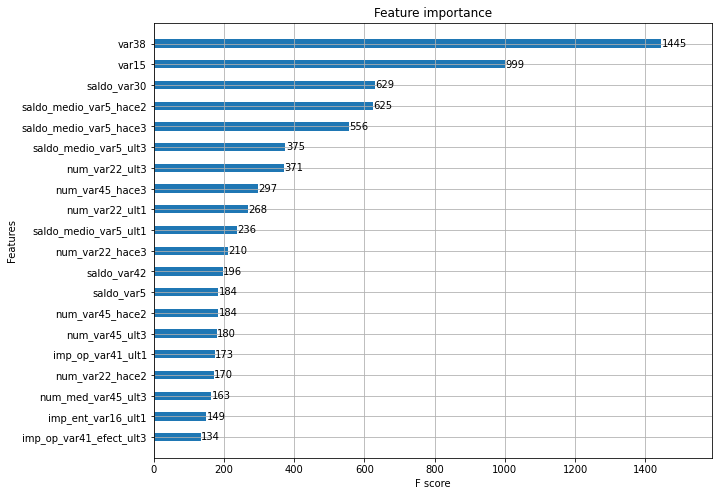

In [ ]:
# 피처 중요도

from xgboost import plot_importance

fig, ax = plt.subplots(figsize = (10, 8))
plot_importance(xgb, ax = ax, max_num_features = 20, height = .4)

## LightGBM 모델 학습 & 하이퍼 파라미터 튜닝

마찬가지로 XGBoost에서 만들어진 데이터 세트를 기반으로 LightGBM 학습을 수행하고 ROC AUC를 측정해봅시다!

In [14]:
tic = time.time()
lgbm = LGBMClassifier (n_estimators = 500, random_state = 156)

lgbm.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", 
         eval_set = [(X_train, y_train), (X_eval, y_eval)])

lgbm_roc_score = roc_auc_score (y_eval, lgbm.predict_proba(X_eval)[:, 1], average = "macro")
toc = time.time()

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.823612	training's binary_logloss: 0.156016	valid_1's auc: 0.817384	valid_1's binary_logloss: 0.165046
[2]	training's auc: 0.827661	training's binary_logloss: 0.150579	valid_1's auc: 0.818903	valid_1's binary_logloss: 0.160006
[3]	training's auc: 0.837671	training's binary_logloss: 0.146617	valid_1's auc: 0.827707	valid_1's binary_logloss: 0.156323
[4]	training's auc: 0.843171	training's binary_logloss: 0.143452	valid_1's auc: 0.832155	valid_1's binary_logloss: 0.153463
[5]	training's auc: 0.845828	training's binary_logloss: 0.140934	valid_1's auc: 0.834677	valid_1's binary_logloss: 0.151256
[6]	training's auc: 0.846531	training's binary_logloss: 0.138851	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.149427
[7]	training's auc: 0.850239	training's binary_logloss: 0.136968	valid_1's auc: 0.837046	valid_1's binary_logloss: 0.147961
[8]	training's auc: 0.852495	training's binary_logloss: 0.135451	valid_1's auc: 0.837838	valid_1's binary_logloss: 0.146591
[9]	trai

[74]	training's auc: 0.913898	training's binary_logloss: 0.110129	valid_1's auc: 0.837912	valid_1's binary_logloss: 0.139905
[75]	training's auc: 0.914706	training's binary_logloss: 0.109869	valid_1's auc: 0.83772	valid_1's binary_logloss: 0.13992
[76]	training's auc: 0.915103	training's binary_logloss: 0.109675	valid_1's auc: 0.837606	valid_1's binary_logloss: 0.139899
[77]	training's auc: 0.91523	training's binary_logloss: 0.109574	valid_1's auc: 0.837521	valid_1's binary_logloss: 0.139925
[78]	training's auc: 0.915607	training's binary_logloss: 0.109377	valid_1's auc: 0.837462	valid_1's binary_logloss: 0.139957
[79]	training's auc: 0.915934	training's binary_logloss: 0.1092	valid_1's auc: 0.837541	valid_1's binary_logloss: 0.139944
[80]	training's auc: 0.916607	training's binary_logloss: 0.108946	valid_1's auc: 0.838013	valid_1's binary_logloss: 0.13983
[81]	training's auc: 0.916807	training's binary_logloss: 0.108795	valid_1's auc: 0.83789	valid_1's binary_logloss: 0.139874
[82]	tr

결과는 ROC AUC는 0.8396, 걸린 시간은 12초네요!

튜닝을 하지 않은 XGBoost의 결과와 비교했을 때, ROC AUC는 0.0023 더 낮고, 시간은 약 165초 더 빠르게 나왔네요!

마찬가지로 GridSearchCV로 하이퍼 파라미터 튜닝을 수행해봅시다!

In [15]:
tic = time.time()

params = {
    'max_depth':[128, 160],
    'min_child_samples':[60, 100],
    'subsample':[0.8, 1]
}
lgbm = LGBMClassifier(n_estimator = 100)

gridcv = GridSearchCV(lgbm, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
          eval_set = [(X_train, y_train), (X_eval, y_eval)])

lgbm_roc_score = roc_auc_score(y_eval, gridcv.predict_proba(X_eval)[:,1], average = 'macro')

toc = time.time()

print('Optimized hyperparameters', gridcv.best_params_)
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.820107	valid_0's binary_logloss: 0.156116	valid_1's auc: 0.815632	valid_1's binary_logloss: 0.165023
[2]	valid_0's auc: 0.825543	valid_0's binary_logloss: 0.151001	valid_1's auc: 0.821373	valid_1's binary_logloss: 0.159945
[3]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.147249	valid_1's auc: 0.826189	valid_1's binary_logloss: 0.156372
[4]	valid_0's auc: 0.837249	valid_0's binary_logloss: 0.144258	valid_1's auc: 0.83307	valid_1's binary_logloss: 0.153399
[5]	valid_0's auc: 0.841358	valid_0's binary_logloss: 0.141884	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.151079
[6]	valid_0's auc: 0.843532	valid_0's binary_logloss: 0.139902	valid_1's auc: 0.83696	valid_1's binary_logloss: 0.149223
[7]	valid_0's auc: 0.845572	valid_0's binary_logloss: 0.138268	valid_1's auc: 0.839347	valid_1's binary_logloss: 0.147475
[8]	valid_0's auc: 0.847989	valid_0's binary_logloss: 0.136862	valid_1's auc: 0.840152	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.814409	valid_0's binary_logloss: 0.156453	valid_1's auc: 0.813191	valid_1's binary_logloss: 0.1654
[2]	valid_0's auc: 0.827239	valid_0's binary_logloss: 0.151091	valid_1's auc: 0.819589	valid_1's binary_logloss: 0.160119
[3]	valid_0's auc: 0.836958	valid_0's binary_logloss: 0.147254	valid_1's auc: 0.828052	valid_1's binary_logloss: 0.156528
[4]	valid_0's auc: 0.840075	valid_0's binary_logloss: 0.144254	valid_1's auc: 0.830576	valid_1's binary_logloss: 0.15359
[5]	valid_0's auc: 0.842405	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832631	valid_1's binary_logloss: 0.151302
[6]	valid_0's auc: 0.84513	valid_0's binary_logloss: 0.139783	valid_1's auc: 0.835654	valid_1's binary_logloss: 0.149357
[7]	valid_0's auc: 0.847603	valid_0's binary_logloss: 0.138115	valid_1's auc: 0.835158	valid_1's binary_logloss: 0.147934
[8]	valid_0's auc: 0.84964	valid_0's binary_logloss: 0.136673	valid_1's auc: 0.835684	valid_1's bi

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.82166	valid_0's binary_logloss: 0.156555	valid_1's auc: 0.818884	valid_1's binary_logloss: 0.165074
[2]	valid_0's auc: 0.8275	valid_0's binary_logloss: 0.151228	valid_1's auc: 0.822224	valid_1's binary_logloss: 0.160016
[3]	valid_0's auc: 0.837962	valid_0's binary_logloss: 0.147321	valid_1's auc: 0.82992	valid_1's binary_logloss: 0.156365
[4]	valid_0's auc: 0.840164	valid_0's binary_logloss: 0.144323	valid_1's auc: 0.832446	valid_1's binary_logloss: 0.153425
[5]	valid_0's auc: 0.84235	valid_0's binary_logloss: 0.141872	valid_1's auc: 0.834635	valid_1's binary_logloss: 0.151099
[6]	valid_0's auc: 0.843803	valid_0's binary_logloss: 0.139812	valid_1's auc: 0.834578	valid_1's binary_logloss: 0.149292
[7]	valid_0's auc: 0.845663	valid_0's binary_logloss: 0.138171	valid_1's auc: 0.835391	valid_1's binary_logloss: 0.147789
[8]	valid_0's auc: 0.847395	valid_0's binary_logloss: 0.136752	valid_1's auc: 0.836785	valid_1's bi

[70]	valid_0's auc: 0.891599	valid_0's binary_logloss: 0.117064	valid_1's auc: 0.839644	valid_1's binary_logloss: 0.139445
[71]	valid_0's auc: 0.891729	valid_0's binary_logloss: 0.116954	valid_1's auc: 0.83928	valid_1's binary_logloss: 0.139577
[72]	valid_0's auc: 0.892048	valid_0's binary_logloss: 0.116779	valid_1's auc: 0.839128	valid_1's binary_logloss: 0.139633


C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.820107	valid_0's binary_logloss: 0.156116	valid_1's auc: 0.815632	valid_1's binary_logloss: 0.165023
[2]	valid_0's auc: 0.825543	valid_0's binary_logloss: 0.151001	valid_1's auc: 0.821373	valid_1's binary_logloss: 0.159945
[3]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.147249	valid_1's auc: 0.826189	valid_1's binary_logloss: 0.156372
[4]	valid_0's auc: 0.837249	valid_0's binary_logloss: 0.144258	valid_1's auc: 0.83307	valid_1's binary_logloss: 0.153399
[5]	valid_0's auc: 0.841358	valid_0's binary_logloss: 0.141884	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.151079
[6]	valid_0's auc: 0.843532	valid_0's binary_logloss: 0.139902	valid_1's auc: 0.83696	valid_1's binary_logloss: 0.149223
[7]	valid_0's auc: 0.845572	valid_0's binary_logloss: 0.138268	valid_1's auc: 0.839347	valid_1's binary_logloss: 0.147475
[8]	valid_0's auc: 0.847989	valid_0's binary_logloss: 0.136862	valid_1's auc: 0.840152	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.814409	valid_0's binary_logloss: 0.156453	valid_1's auc: 0.813191	valid_1's binary_logloss: 0.1654
[2]	valid_0's auc: 0.827239	valid_0's binary_logloss: 0.151091	valid_1's auc: 0.819589	valid_1's binary_logloss: 0.160119
[3]	valid_0's auc: 0.836958	valid_0's binary_logloss: 0.147254	valid_1's auc: 0.828052	valid_1's binary_logloss: 0.156528
[4]	valid_0's auc: 0.840075	valid_0's binary_logloss: 0.144254	valid_1's auc: 0.830576	valid_1's binary_logloss: 0.15359
[5]	valid_0's auc: 0.842405	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832631	valid_1's binary_logloss: 0.151302
[6]	valid_0's auc: 0.84513	valid_0's binary_logloss: 0.139783	valid_1's auc: 0.835654	valid_1's binary_logloss: 0.149357
[7]	valid_0's auc: 0.847603	valid_0's binary_logloss: 0.138115	valid_1's auc: 0.835158	valid_1's binary_logloss: 0.147934
[8]	valid_0's auc: 0.84964	valid_0's binary_logloss: 0.136673	valid_1's auc: 0.835684	valid_1's bi

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.82166	valid_0's binary_logloss: 0.156555	valid_1's auc: 0.818884	valid_1's binary_logloss: 0.165074
[2]	valid_0's auc: 0.8275	valid_0's binary_logloss: 0.151228	valid_1's auc: 0.822224	valid_1's binary_logloss: 0.160016
[3]	valid_0's auc: 0.837962	valid_0's binary_logloss: 0.147321	valid_1's auc: 0.82992	valid_1's binary_logloss: 0.156365
[4]	valid_0's auc: 0.840164	valid_0's binary_logloss: 0.144323	valid_1's auc: 0.832446	valid_1's binary_logloss: 0.153425
[5]	valid_0's auc: 0.84235	valid_0's binary_logloss: 0.141872	valid_1's auc: 0.834635	valid_1's binary_logloss: 0.151099
[6]	valid_0's auc: 0.843803	valid_0's binary_logloss: 0.139812	valid_1's auc: 0.834578	valid_1's binary_logloss: 0.149292
[7]	valid_0's auc: 0.845663	valid_0's binary_logloss: 0.138171	valid_1's auc: 0.835391	valid_1's binary_logloss: 0.147789
[8]	valid_0's auc: 0.847395	valid_0's binary_logloss: 0.136752	valid_1's auc: 0.836785	valid_1's bi

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.824771	valid_0's binary_logloss: 0.156249	valid_1's auc: 0.817793	valid_1's binary_logloss: 0.165102
[2]	valid_0's auc: 0.828535	valid_0's binary_logloss: 0.151281	valid_1's auc: 0.823189	valid_1's binary_logloss: 0.160178
[3]	valid_0's auc: 0.835411	valid_0's binary_logloss: 0.147483	valid_1's auc: 0.828532	valid_1's binary_logloss: 0.15649
[4]	valid_0's auc: 0.839239	valid_0's binary_logloss: 0.144503	valid_1's auc: 0.832454	valid_1's binary_logloss: 0.153535
[5]	valid_0's auc: 0.842214	valid_0's binary_logloss: 0.142121	valid_1's auc: 0.834304	valid_1's binary_logloss: 0.151216
[6]	valid_0's auc: 0.845112	valid_0's binary_logloss: 0.14023	valid_1's auc: 0.833606	valid_1's binary_logloss: 0.149478
[7]	valid_0's auc: 0.846839	valid_0's binary_logloss: 0.138573	valid_1's auc: 0.834745	valid_1's binary_logloss: 0.147891
[8]	valid_0's auc: 0.847792	valid_0's binary_logloss: 0.137228	valid_1's auc: 0.835658	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821813	valid_0's binary_logloss: 0.156482	valid_1's auc: 0.817437	valid_1's binary_logloss: 0.165222
[2]	valid_0's auc: 0.831781	valid_0's binary_logloss: 0.151161	valid_1's auc: 0.825583	valid_1's binary_logloss: 0.159701
[3]	valid_0's auc: 0.838702	valid_0's binary_logloss: 0.147364	valid_1's auc: 0.831291	valid_1's binary_logloss: 0.15603
[4]	valid_0's auc: 0.84286	valid_0's binary_logloss: 0.144418	valid_1's auc: 0.835063	valid_1's binary_logloss: 0.153109
[5]	valid_0's auc: 0.844629	valid_0's binary_logloss: 0.142076	valid_1's auc: 0.837914	valid_1's binary_logloss: 0.150746
[6]	valid_0's auc: 0.847232	valid_0's binary_logloss: 0.140069	valid_1's auc: 0.840004	valid_1's binary_logloss: 0.148786
[7]	valid_0's auc: 0.848479	valid_0's binary_logloss: 0.13838	valid_1's auc: 0.840063	valid_1's binary_logloss: 0.147378
[8]	valid_0's auc: 0.851191	valid_0's binary_logloss: 0.136973	valid_1's auc: 0.838729	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821372	valid_0's binary_logloss: 0.156607	valid_1's auc: 0.817319	valid_1's binary_logloss: 0.165251
[2]	valid_0's auc: 0.827767	valid_0's binary_logloss: 0.151379	valid_1's auc: 0.820742	valid_1's binary_logloss: 0.160263
[3]	valid_0's auc: 0.837338	valid_0's binary_logloss: 0.14754	valid_1's auc: 0.828985	valid_1's binary_logloss: 0.156549
[4]	valid_0's auc: 0.840199	valid_0's binary_logloss: 0.144519	valid_1's auc: 0.831475	valid_1's binary_logloss: 0.153611
[5]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.142185	valid_1's auc: 0.83374	valid_1's binary_logloss: 0.151385
[6]	valid_0's auc: 0.843533	valid_0's binary_logloss: 0.140149	valid_1's auc: 0.834243	valid_1's binary_logloss: 0.149492
[7]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13857	valid_1's auc: 0.834698	valid_1's binary_logloss: 0.147987
[8]	valid_0's auc: 0.846564	valid_0's binary_logloss: 0.137157	valid_1's auc: 0.835053	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.824771	valid_0's binary_logloss: 0.156249	valid_1's auc: 0.817793	valid_1's binary_logloss: 0.165102
[2]	valid_0's auc: 0.828535	valid_0's binary_logloss: 0.151281	valid_1's auc: 0.823189	valid_1's binary_logloss: 0.160178
[3]	valid_0's auc: 0.835411	valid_0's binary_logloss: 0.147483	valid_1's auc: 0.828532	valid_1's binary_logloss: 0.15649
[4]	valid_0's auc: 0.839239	valid_0's binary_logloss: 0.144503	valid_1's auc: 0.832454	valid_1's binary_logloss: 0.153535
[5]	valid_0's auc: 0.842214	valid_0's binary_logloss: 0.142121	valid_1's auc: 0.834304	valid_1's binary_logloss: 0.151216
[6]	valid_0's auc: 0.845112	valid_0's binary_logloss: 0.14023	valid_1's auc: 0.833606	valid_1's binary_logloss: 0.149478
[7]	valid_0's auc: 0.846839	valid_0's binary_logloss: 0.138573	valid_1's auc: 0.834745	valid_1's binary_logloss: 0.147891
[8]	valid_0's auc: 0.847792	valid_0's binary_logloss: 0.137228	valid_1's auc: 0.835658	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821813	valid_0's binary_logloss: 0.156482	valid_1's auc: 0.817437	valid_1's binary_logloss: 0.165222
[2]	valid_0's auc: 0.831781	valid_0's binary_logloss: 0.151161	valid_1's auc: 0.825583	valid_1's binary_logloss: 0.159701
[3]	valid_0's auc: 0.838702	valid_0's binary_logloss: 0.147364	valid_1's auc: 0.831291	valid_1's binary_logloss: 0.15603
[4]	valid_0's auc: 0.84286	valid_0's binary_logloss: 0.144418	valid_1's auc: 0.835063	valid_1's binary_logloss: 0.153109
[5]	valid_0's auc: 0.844629	valid_0's binary_logloss: 0.142076	valid_1's auc: 0.837914	valid_1's binary_logloss: 0.150746
[6]	valid_0's auc: 0.847232	valid_0's binary_logloss: 0.140069	valid_1's auc: 0.840004	valid_1's binary_logloss: 0.148786
[7]	valid_0's auc: 0.848479	valid_0's binary_logloss: 0.13838	valid_1's auc: 0.840063	valid_1's binary_logloss: 0.147378
[8]	valid_0's auc: 0.851191	valid_0's binary_logloss: 0.136973	valid_1's auc: 0.838729	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821372	valid_0's binary_logloss: 0.156607	valid_1's auc: 0.817319	valid_1's binary_logloss: 0.165251
[2]	valid_0's auc: 0.827767	valid_0's binary_logloss: 0.151379	valid_1's auc: 0.820742	valid_1's binary_logloss: 0.160263
[3]	valid_0's auc: 0.837338	valid_0's binary_logloss: 0.14754	valid_1's auc: 0.828985	valid_1's binary_logloss: 0.156549
[4]	valid_0's auc: 0.840199	valid_0's binary_logloss: 0.144519	valid_1's auc: 0.831475	valid_1's binary_logloss: 0.153611
[5]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.142185	valid_1's auc: 0.83374	valid_1's binary_logloss: 0.151385
[6]	valid_0's auc: 0.843533	valid_0's binary_logloss: 0.140149	valid_1's auc: 0.834243	valid_1's binary_logloss: 0.149492
[7]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13857	valid_1's auc: 0.834698	valid_1's binary_logloss: 0.147987
[8]	valid_0's auc: 0.846564	valid_0's binary_logloss: 0.137157	valid_1's auc: 0.835053	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.820107	valid_0's binary_logloss: 0.156116	valid_1's auc: 0.815632	valid_1's binary_logloss: 0.165023
[2]	valid_0's auc: 0.825543	valid_0's binary_logloss: 0.151001	valid_1's auc: 0.821373	valid_1's binary_logloss: 0.159945
[3]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.147249	valid_1's auc: 0.826189	valid_1's binary_logloss: 0.156372
[4]	valid_0's auc: 0.837249	valid_0's binary_logloss: 0.144258	valid_1's auc: 0.83307	valid_1's binary_logloss: 0.153399
[5]	valid_0's auc: 0.841358	valid_0's binary_logloss: 0.141884	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.151079
[6]	valid_0's auc: 0.843532	valid_0's binary_logloss: 0.139902	valid_1's auc: 0.83696	valid_1's binary_logloss: 0.149223
[7]	valid_0's auc: 0.845572	valid_0's binary_logloss: 0.138268	valid_1's auc: 0.839347	valid_1's binary_logloss: 0.147475
[8]	valid_0's auc: 0.847989	valid_0's binary_logloss: 0.136862	valid_1's auc: 0.840152	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.814409	valid_0's binary_logloss: 0.156453	valid_1's auc: 0.813191	valid_1's binary_logloss: 0.1654
[2]	valid_0's auc: 0.827239	valid_0's binary_logloss: 0.151091	valid_1's auc: 0.819589	valid_1's binary_logloss: 0.160119
[3]	valid_0's auc: 0.836958	valid_0's binary_logloss: 0.147254	valid_1's auc: 0.828052	valid_1's binary_logloss: 0.156528
[4]	valid_0's auc: 0.840075	valid_0's binary_logloss: 0.144254	valid_1's auc: 0.830576	valid_1's binary_logloss: 0.15359
[5]	valid_0's auc: 0.842405	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832631	valid_1's binary_logloss: 0.151302
[6]	valid_0's auc: 0.84513	valid_0's binary_logloss: 0.139783	valid_1's auc: 0.835654	valid_1's binary_logloss: 0.149357
[7]	valid_0's auc: 0.847603	valid_0's binary_logloss: 0.138115	valid_1's auc: 0.835158	valid_1's binary_logloss: 0.147934
[8]	valid_0's auc: 0.84964	valid_0's binary_logloss: 0.136673	valid_1's auc: 0.835684	valid_1's bi

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.82166	valid_0's binary_logloss: 0.156555	valid_1's auc: 0.818884	valid_1's binary_logloss: 0.165074
[2]	valid_0's auc: 0.8275	valid_0's binary_logloss: 0.151228	valid_1's auc: 0.822224	valid_1's binary_logloss: 0.160016
[3]	valid_0's auc: 0.837962	valid_0's binary_logloss: 0.147321	valid_1's auc: 0.82992	valid_1's binary_logloss: 0.156365
[4]	valid_0's auc: 0.840164	valid_0's binary_logloss: 0.144323	valid_1's auc: 0.832446	valid_1's binary_logloss: 0.153425
[5]	valid_0's auc: 0.84235	valid_0's binary_logloss: 0.141872	valid_1's auc: 0.834635	valid_1's binary_logloss: 0.151099
[6]	valid_0's auc: 0.843803	valid_0's binary_logloss: 0.139812	valid_1's auc: 0.834578	valid_1's binary_logloss: 0.149292
[7]	valid_0's auc: 0.845663	valid_0's binary_logloss: 0.138171	valid_1's auc: 0.835391	valid_1's binary_logloss: 0.147789
[8]	valid_0's auc: 0.847395	valid_0's binary_logloss: 0.136752	valid_1's auc: 0.836785	valid_1's bi

[72]	valid_0's auc: 0.892048	valid_0's binary_logloss: 0.116779	valid_1's auc: 0.839128	valid_1's binary_logloss: 0.139633


C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.820107	valid_0's binary_logloss: 0.156116	valid_1's auc: 0.815632	valid_1's binary_logloss: 0.165023
[2]	valid_0's auc: 0.825543	valid_0's binary_logloss: 0.151001	valid_1's auc: 0.821373	valid_1's binary_logloss: 0.159945
[3]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.147249	valid_1's auc: 0.826189	valid_1's binary_logloss: 0.156372
[4]	valid_0's auc: 0.837249	valid_0's binary_logloss: 0.144258	valid_1's auc: 0.83307	valid_1's binary_logloss: 0.153399
[5]	valid_0's auc: 0.841358	valid_0's binary_logloss: 0.141884	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.151079
[6]	valid_0's auc: 0.843532	valid_0's binary_logloss: 0.139902	valid_1's auc: 0.83696	valid_1's binary_logloss: 0.149223
[7]	valid_0's auc: 0.845572	valid_0's binary_logloss: 0.138268	valid_1's auc: 0.839347	valid_1's binary_logloss: 0.147475
[8]	valid_0's auc: 0.847989	valid_0's binary_logloss: 0.136862	valid_1's auc: 0.840152	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.814409	valid_0's binary_logloss: 0.156453	valid_1's auc: 0.813191	valid_1's binary_logloss: 0.1654
[2]	valid_0's auc: 0.827239	valid_0's binary_logloss: 0.151091	valid_1's auc: 0.819589	valid_1's binary_logloss: 0.160119
[3]	valid_0's auc: 0.836958	valid_0's binary_logloss: 0.147254	valid_1's auc: 0.828052	valid_1's binary_logloss: 0.156528
[4]	valid_0's auc: 0.840075	valid_0's binary_logloss: 0.144254	valid_1's auc: 0.830576	valid_1's binary_logloss: 0.15359
[5]	valid_0's auc: 0.842405	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832631	valid_1's binary_logloss: 0.151302
[6]	valid_0's auc: 0.84513	valid_0's binary_logloss: 0.139783	valid_1's auc: 0.835654	valid_1's binary_logloss: 0.149357
[7]	valid_0's auc: 0.847603	valid_0's binary_logloss: 0.138115	valid_1's auc: 0.835158	valid_1's binary_logloss: 0.147934
[8]	valid_0's auc: 0.84964	valid_0's binary_logloss: 0.136673	valid_1's auc: 0.835684	valid_1's bi

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.82166	valid_0's binary_logloss: 0.156555	valid_1's auc: 0.818884	valid_1's binary_logloss: 0.165074
[2]	valid_0's auc: 0.8275	valid_0's binary_logloss: 0.151228	valid_1's auc: 0.822224	valid_1's binary_logloss: 0.160016
[3]	valid_0's auc: 0.837962	valid_0's binary_logloss: 0.147321	valid_1's auc: 0.82992	valid_1's binary_logloss: 0.156365
[4]	valid_0's auc: 0.840164	valid_0's binary_logloss: 0.144323	valid_1's auc: 0.832446	valid_1's binary_logloss: 0.153425
[5]	valid_0's auc: 0.84235	valid_0's binary_logloss: 0.141872	valid_1's auc: 0.834635	valid_1's binary_logloss: 0.151099
[6]	valid_0's auc: 0.843803	valid_0's binary_logloss: 0.139812	valid_1's auc: 0.834578	valid_1's binary_logloss: 0.149292
[7]	valid_0's auc: 0.845663	valid_0's binary_logloss: 0.138171	valid_1's auc: 0.835391	valid_1's binary_logloss: 0.147789
[8]	valid_0's auc: 0.847395	valid_0's binary_logloss: 0.136752	valid_1's auc: 0.836785	valid_1's bi

[72]	valid_0's auc: 0.892048	valid_0's binary_logloss: 0.116779	valid_1's auc: 0.839128	valid_1's binary_logloss: 0.139633


C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.824771	valid_0's binary_logloss: 0.156249	valid_1's auc: 0.817793	valid_1's binary_logloss: 0.165102
[2]	valid_0's auc: 0.828535	valid_0's binary_logloss: 0.151281	valid_1's auc: 0.823189	valid_1's binary_logloss: 0.160178
[3]	valid_0's auc: 0.835411	valid_0's binary_logloss: 0.147483	valid_1's auc: 0.828532	valid_1's binary_logloss: 0.15649
[4]	valid_0's auc: 0.839239	valid_0's binary_logloss: 0.144503	valid_1's auc: 0.832454	valid_1's binary_logloss: 0.153535
[5]	valid_0's auc: 0.842214	valid_0's binary_logloss: 0.142121	valid_1's auc: 0.834304	valid_1's binary_logloss: 0.151216
[6]	valid_0's auc: 0.845112	valid_0's binary_logloss: 0.14023	valid_1's auc: 0.833606	valid_1's binary_logloss: 0.149478
[7]	valid_0's auc: 0.846839	valid_0's binary_logloss: 0.138573	valid_1's auc: 0.834745	valid_1's binary_logloss: 0.147891
[8]	valid_0's auc: 0.847792	valid_0's binary_logloss: 0.137228	valid_1's auc: 0.835658	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821813	valid_0's binary_logloss: 0.156482	valid_1's auc: 0.817437	valid_1's binary_logloss: 0.165222
[2]	valid_0's auc: 0.831781	valid_0's binary_logloss: 0.151161	valid_1's auc: 0.825583	valid_1's binary_logloss: 0.159701
[3]	valid_0's auc: 0.838702	valid_0's binary_logloss: 0.147364	valid_1's auc: 0.831291	valid_1's binary_logloss: 0.15603
[4]	valid_0's auc: 0.84286	valid_0's binary_logloss: 0.144418	valid_1's auc: 0.835063	valid_1's binary_logloss: 0.153109
[5]	valid_0's auc: 0.844629	valid_0's binary_logloss: 0.142076	valid_1's auc: 0.837914	valid_1's binary_logloss: 0.150746
[6]	valid_0's auc: 0.847232	valid_0's binary_logloss: 0.140069	valid_1's auc: 0.840004	valid_1's binary_logloss: 0.148786
[7]	valid_0's auc: 0.848479	valid_0's binary_logloss: 0.13838	valid_1's auc: 0.840063	valid_1's binary_logloss: 0.147378
[8]	valid_0's auc: 0.851191	valid_0's binary_logloss: 0.136973	valid_1's auc: 0.838729	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821372	valid_0's binary_logloss: 0.156607	valid_1's auc: 0.817319	valid_1's binary_logloss: 0.165251
[2]	valid_0's auc: 0.827767	valid_0's binary_logloss: 0.151379	valid_1's auc: 0.820742	valid_1's binary_logloss: 0.160263
[3]	valid_0's auc: 0.837338	valid_0's binary_logloss: 0.14754	valid_1's auc: 0.828985	valid_1's binary_logloss: 0.156549
[4]	valid_0's auc: 0.840199	valid_0's binary_logloss: 0.144519	valid_1's auc: 0.831475	valid_1's binary_logloss: 0.153611
[5]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.142185	valid_1's auc: 0.83374	valid_1's binary_logloss: 0.151385
[6]	valid_0's auc: 0.843533	valid_0's binary_logloss: 0.140149	valid_1's auc: 0.834243	valid_1's binary_logloss: 0.149492
[7]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13857	valid_1's auc: 0.834698	valid_1's binary_logloss: 0.147987
[8]	valid_0's auc: 0.846564	valid_0's binary_logloss: 0.137157	valid_1's auc: 0.835053	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.824771	valid_0's binary_logloss: 0.156249	valid_1's auc: 0.817793	valid_1's binary_logloss: 0.165102
[2]	valid_0's auc: 0.828535	valid_0's binary_logloss: 0.151281	valid_1's auc: 0.823189	valid_1's binary_logloss: 0.160178
[3]	valid_0's auc: 0.835411	valid_0's binary_logloss: 0.147483	valid_1's auc: 0.828532	valid_1's binary_logloss: 0.15649
[4]	valid_0's auc: 0.839239	valid_0's binary_logloss: 0.144503	valid_1's auc: 0.832454	valid_1's binary_logloss: 0.153535
[5]	valid_0's auc: 0.842214	valid_0's binary_logloss: 0.142121	valid_1's auc: 0.834304	valid_1's binary_logloss: 0.151216
[6]	valid_0's auc: 0.845112	valid_0's binary_logloss: 0.14023	valid_1's auc: 0.833606	valid_1's binary_logloss: 0.149478
[7]	valid_0's auc: 0.846839	valid_0's binary_logloss: 0.138573	valid_1's auc: 0.834745	valid_1's binary_logloss: 0.147891
[8]	valid_0's auc: 0.847792	valid_0's binary_logloss: 0.137228	valid_1's auc: 0.835658	valid_1's

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821813	valid_0's binary_logloss: 0.156482	valid_1's auc: 0.817437	valid_1's binary_logloss: 0.165222
[2]	valid_0's auc: 0.831781	valid_0's binary_logloss: 0.151161	valid_1's auc: 0.825583	valid_1's binary_logloss: 0.159701
[3]	valid_0's auc: 0.838702	valid_0's binary_logloss: 0.147364	valid_1's auc: 0.831291	valid_1's binary_logloss: 0.15603
[4]	valid_0's auc: 0.84286	valid_0's binary_logloss: 0.144418	valid_1's auc: 0.835063	valid_1's binary_logloss: 0.153109
[5]	valid_0's auc: 0.844629	valid_0's binary_logloss: 0.142076	valid_1's auc: 0.837914	valid_1's binary_logloss: 0.150746
[6]	valid_0's auc: 0.847232	valid_0's binary_logloss: 0.140069	valid_1's auc: 0.840004	valid_1's binary_logloss: 0.148786
[7]	valid_0's auc: 0.848479	valid_0's binary_logloss: 0.13838	valid_1's auc: 0.840063	valid_1's binary_logloss: 0.147378
[8]	valid_0's auc: 0.851191	valid_0's binary_logloss: 0.136973	valid_1's auc: 0.838729	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821372	valid_0's binary_logloss: 0.156607	valid_1's auc: 0.817319	valid_1's binary_logloss: 0.165251
[2]	valid_0's auc: 0.827767	valid_0's binary_logloss: 0.151379	valid_1's auc: 0.820742	valid_1's binary_logloss: 0.160263
[3]	valid_0's auc: 0.837338	valid_0's binary_logloss: 0.14754	valid_1's auc: 0.828985	valid_1's binary_logloss: 0.156549
[4]	valid_0's auc: 0.840199	valid_0's binary_logloss: 0.144519	valid_1's auc: 0.831475	valid_1's binary_logloss: 0.153611
[5]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.142185	valid_1's auc: 0.83374	valid_1's binary_logloss: 0.151385
[6]	valid_0's auc: 0.843533	valid_0's binary_logloss: 0.140149	valid_1's auc: 0.834243	valid_1's binary_logloss: 0.149492
[7]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13857	valid_1's auc: 0.834698	valid_1's binary_logloss: 0.147987
[8]	valid_0's auc: 0.846564	valid_0's binary_logloss: 0.137157	valid_1's auc: 0.835053	valid_1's 

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	training's auc: 0.823544	training's binary_logloss: 0.156167	valid_1's auc: 0.81662	valid_1's binary_logloss: 0.165164
[2]	training's auc: 0.827956	training's binary_logloss: 0.150935	valid_1's auc: 0.819528	valid_1's binary_logloss: 0.160021
[3]	training's auc: 0.837575	training's binary_logloss: 0.147071	valid_1's auc: 0.827643	valid_1's binary_logloss: 0.156404
[4]	training's auc: 0.843112	training's binary_logloss: 0.144068	valid_1's auc: 0.833009	valid_1's binary_logloss: 0.153515
[5]	training's auc: 0.845906	training's binary_logloss: 0.141647	valid_1's auc: 0.835136	valid_1's binary_logloss: 0.151349
[6]	training's auc: 0.84835	training's binary_logloss: 0.139572	valid_1's auc: 0.836927	valid_1's binary_logloss: 0.149462
[7]	training's auc: 0.851387	training's binary_logloss: 0.137804	valid_1's auc: 0.838409	valid_1's binary_logloss: 0.147896
[8]	training's auc: 0.853134	training's binary_logloss: 0.136347	valid_1's auc: 0.

기존에 약 20분이 걸렸던 XGBoost의 GridSearchCV에 비해 LightGBM의 GridSearchCV는 2분이면 완성이네요!

ROC AUC는 0.8416, 최적의 하이퍼 파라미터는 {‘max_depth’: 128, ‘min_child_samples’: 60, ‘subsample’: 0.8}입니다!

마지막으로 해당 하이퍼 파라미터를 LightGBM에 적용해 다시 학습한 결과입니다!

In [16]:
tic = time.time()

lgbm = LGBMClassifier(n_estimators = 1000, max_depth = 128,
                      min_child_samples = 60, subsample = 0.8,
                      random_state = 156)
lgbm.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc",
         eval_set = [(X_train, y_train), (X_eval, y_eval)])
lgbm_roc_score = roc_auc_score(y_eval, lgbm.predict_proba(X_eval)[:,1], average = 'macro')

toc = time.time()

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.823544	training's binary_logloss: 0.156167	valid_1's auc: 0.81662	valid_1's binary_logloss: 0.165164
[2]	training's auc: 0.827956	training's binary_logloss: 0.150935	valid_1's auc: 0.819528	valid_1's binary_logloss: 0.160021
[3]	training's auc: 0.837575	training's binary_logloss: 0.147071	valid_1's auc: 0.827643	valid_1's binary_logloss: 0.156404
[4]	training's auc: 0.843112	training's binary_logloss: 0.144068	valid_1's auc: 0.833009	valid_1's binary_logloss: 0.153515
[5]	training's auc: 0.845906	training's binary_logloss: 0.141647	valid_1's auc: 0.835136	valid_1's binary_logloss: 0.151349
[6]	training's auc: 0.84835	training's binary_logloss: 0.139572	valid_1's auc: 0.836927	valid_1's binary_logloss: 0.149462
[7]	training's auc: 0.851387	training's binary_logloss: 0.137804	valid_1's auc: 0.838409	valid_1's binary_logloss: 0.147896
[8]	training's auc: 0.853134	training's binary_logloss: 0.136347	valid_1's auc: 0.839594	valid_1's binary_logloss: 0.146662
[9]	traini

[70]	training's auc: 0.906844	training's binary_logloss: 0.113621	valid_1's auc: 0.83956	valid_1's binary_logloss: 0.139168
[71]	training's auc: 0.907287	training's binary_logloss: 0.113391	valid_1's auc: 0.839596	valid_1's binary_logloss: 0.139197
[72]	training's auc: 0.907858	training's binary_logloss: 0.113215	valid_1's auc: 0.839501	valid_1's binary_logloss: 0.13923
[73]	training's auc: 0.908478	training's binary_logloss: 0.112986	valid_1's auc: 0.83899	valid_1's binary_logloss: 0.139323
[74]	training's auc: 0.908907	training's binary_logloss: 0.112793	valid_1's auc: 0.839088	valid_1's binary_logloss: 0.139283
[75]	training's auc: 0.909425	training's binary_logloss: 0.112568	valid_1's auc: 0.839282	valid_1's binary_logloss: 0.139263
[76]	training's auc: 0.909769	training's binary_logloss: 0.112416	valid_1's auc: 0.839162	valid_1's binary_logloss: 0.139289
[77]	training's auc: 0.910228	training's binary_logloss: 0.112239	valid_1's auc: 0.839005	valid_1's binary_logloss: 0.139311
[78

똑같이 ROC AUC는 0.8416이 나왔고, 소요 시간은 9초입니다!

결과적으로, 소수점 둘째 자리까지 ROC AUC 값이 같을 정도로 XGBoost만큼 LightGBM도 우수한 성능을 낸다는 점, 시간이 훨씬 절약된다는 점을 고려했을 때, LightGBM의 승리라고 생각됩니다! 하지만 데이터에 따라 결과는 언제든 달라질 수 있으니 꼭 둘 다 확인해봅시다!